# carboxysome foci Spideymapping

## Imports

In [2]:
from glob import glob
from os.path import join

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import ndimage as ndi
import seaborn as sns
import shapely as sl
from skimage.measure import find_contours
from skimage.measure import regionprops_table
from skimage.morphology import binary_opening, disk
import tifffile

from spideymaps import Spideymap, SpideyAtlas, smooth_spine, get_color

## Load data

In [3]:
folder = r"L:\MIGRATED\Lab_Members\Chris_Azaldegui\Project_Hn\Av_scope\2024-05-26\loop_label\data"
data_name = 'PAmC_SW'

locs_files = glob(join(folder, "*cbcells.csv"))
labels_files = glob(join(folder, "*PhaseMask.tif"))

locs = [pd.read_csv(file) for file in locs_files[:]]
labels = [tifffile.imread(file) for file in labels_files[:]]
print(len(labels))

23


## Prepare data

In [4]:
# nested loop to iterate through each image
# save locs_bbox into a list for mapping
bound_boxes = []
for loc, label in zip(locs, labels):
    loc['CBS_LOCS'] = loc['CBS_LOCS'].apply(eval) # de-string
    locs_exploded = loc.explode("CBS_LOCS").reset_index(drop=True) # put each 4-tuple on its own row
    locs_exploded = locs_exploded[locs_exploded['CBS_LOCS'] != 'none'] # exclude cells without foci
    locs_exploded[['x', 'y', 'r', 'a']] = pd.DataFrame(locs_exploded['CBS_LOCS'].tolist(), # split tuples into individual columns
                                                  index=locs_exploded.index)

    bboxes = regionprops_table(label_image=label.astype(int), properties=('label', 'bbox',)) # find bounding box for each cell (dict)
    bboxes_df = pd.DataFrame(data=bboxes) # dict to DataFrame
    locs_bbox = pd.merge(locs_exploded, bboxes_df, left_on='CELL_ID', right_on="label") # combine 

    # compute absolute coordinates (relative to labels) by adding minima of bounding box
    locs_bbox['x_abs'] = locs_bbox['x'] + locs_bbox['bbox-1'] - 1 # subtract 1 because bounding box for detection was padded
    locs_bbox['y_abs'] = locs_bbox['y'] + locs_bbox['bbox-0'] - 1
    bound_boxes.append(locs_bbox)

# sanity check
print(len(bound_boxes))

23


## Perform mapping

In [6]:
maps = []

for label, locs_bbox in zip(labels, bound_boxes):
    # for index, row in bboxes_df.iterrows():
    for cell_id in locs_bbox['CELL_ID'].unique():
        
        locs_cell = locs_bbox[locs_bbox['CELL_ID'] == cell_id]
        rowmin = locs_cell['bbox-0'].iloc[0]
        rowmax = locs_cell['bbox-2'].iloc[0]
        colmin = locs_cell['bbox-1'].iloc[0]
        colmax = locs_cell['bbox-3'].iloc[0]
        bb_image = label[rowmin:rowmax, colmin:colmax]
        cell_bool = bb_image == cell_id # generate binary image
        cell_bool = np.pad(cell_bool, pad_width=1, mode='constant', constant_values=0) # pad to not screw up contour finding, match detection
        cell_bool = binary_opening(cell_bool, footprint=disk(2))
        out = find_contours(cell_bool, level=0.5)[0][:,::-1] # outline, use first, xy-format
        out = smooth_spine(out, sigma=0.5)
        out = sl.LinearRing(out)
        map = Spideymap(bimage=cell_bool, coords=locs_cell, xcol='x', ycol='y')
        
        try:
             map.make_grid(out=out, radius=9, n_shells=5, n_cols=12, n_phi=(1,3,5,5,5), level=0)
             map.count()
             maps.append(map)
                           
        except:
             continue
        
print("num cells", len(maps))
atlas = SpideyAtlas(maps)

atlas.create_rep_grid(
    grid_params = dict(radius=5, n_shells=5, n_cols=12, n_phi=(1,3,5,5,5), outpars=dict(sigma=0.5)), 
    mode = 'binaries'
    )

C:\Users\azaldegc\Desktop\jupyter_dow\mapping\spideymaps\spideymaps_calculation.py:360: RuntimeWarning: divide by zero encountered in scalar divide
  probe = LineString(np.array([[x0,y0], (diag/mag)*v + np.array([x0,y0])]))
C:\Users\azaldegc\Desktop\jupyter_dow\mapping\spideymaps\spideymaps_calculation.py:360: RuntimeWarning: invalid value encountered in multiply
  probe = LineString(np.array([[x0,y0], (diag/mag)*v + np.array([x0,y0])]))
C:\Users\azaldegc\Desktop\jupyter_dow\mapping\spideymaps\spideymaps_calculation.py:370: RuntimeWarning: divide by zero encountered in scalar divide
  probe = LineString(np.array([[x0,y0], (diag/mag)*v + np.array([x0,y0])]))
C:\Users\azaldegc\Desktop\jupyter_dow\mapping\spideymaps\spideymaps_calculation.py:370: RuntimeWarning: invalid value encountered in multiply
  probe = LineString(np.array([[x0,y0], (diag/mag)*v + np.array([x0,y0])]))
C:\Users\azaldegc\Desktop\jupyter_dow\mapping\spideymaps\spideymaps_calculation.py:360: RuntimeWarning: divide by ze

num cells 987


In [7]:
atlas.create_rep_grid(
    grid_params = dict(radius=5, n_shells=5, n_cols=12, n_phi=(1,3,5,5,5), outpars=dict(sigma=0.1)), 
    mode = 'binaries'
    )

In [8]:
atlas.sum_maps(col_name='count') # sum map level data
atlas.sum_maps(col_name='area')
atlas.add_symmetric_elements(col_name='count')
atlas.add_symmetric_elements(col_name='area')
atlas.data['counts_per_area_sym'] = atlas.data['count_symsum'] / atlas.data['area_symsum']

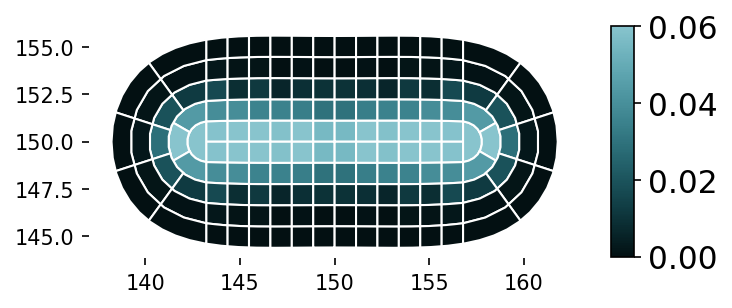

In [9]:
# from spideymaps import render_map
def render_map(polygons_dict, values_dict, vmin=None, vmax=None, cmap=None):

    if cmap is None: cmap = sns.cubehelix_palette(start=2.5, rot=0, dark=0.05, hue=1,
                                                  light=.7, reverse=True, as_cmap=True)
    values_array = np.array(list(values_dict.values()))
    if vmin is None:
        vmin = np.nanmin(values_array)
    if vmax is None:
        vmax = np.nanmax(values_array)

    sm = ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax, clip=True), cmap=cmap)

    fig, ax = plt.subplots(figsize=(5,2.5), dpi=150)
    #plt.rcParams.update({'font.size': 9})
    #plt.rcParams['font.family'] = 'Calibri'
    #sns.set(font="Calibri")
    #plt.rcParams['svg.fonttype'] = 'none'
    for key in polygons_dict:
        plt.fill(polygons_dict[key].boundary.xy[0], polygons_dict[key].boundary.xy[1],
                facecolor=get_color(values_dict[key], vmin=vmin, vmax=vmax, cmap=cmap),
                edgecolor='xkcd:white', linewidth=1)
    plt.gca().set_aspect('equal')
    cb = plt.colorbar(mappable=sm, ax=ax, shrink=0.7, aspect=10)
    cb.outline.set_color('xkcd:black')
    cb.ax.tick_params(labelsize=15)

    plt.gca().spines['bottom'].set_color(4*[0])
    plt.gca().spines['top'].set_color(4*[0])
    plt.gca().spines['left'].set_color(4*[0])
    plt.gca().spines['right'].set_color(4*[0])

    plt.gca().set_aspect('equal')
    plt.grid(False)

    return fig, ax

fig, ax = render_map(
    atlas.rep_grid, 
    atlas.data['counts_per_area_sym'].to_dict(), 
    vmin=0, 
    vmax=0.06, 
    cmap=None)

fig.tight_layout()
plt.savefig(folder + '_' + data_name + 'heatmap_symmetric.png', dpi=300)
plt.savefig(folder + '_' + data_name + 'heatmap_symmetric.svg', dpi=300)

In [16]:
## For samples with only once focus, can orient cells by focus location. Not recommended for cells with multiple foci

In [11]:
atlas_coords_copy = atlas.coords.copy()

In [12]:
atlas.coords = atlas_coords_copy

i_l_max = 13
i_l_mid = i_l_max / 2

atlas.coords['multifoci'] = atlas.coords.duplicated(subset='CELL_ID', keep=False) # ignore >1 foci
atlas.coords['polarity'] = np.where(atlas.coords['i_l'] <= i_l_mid, 'left', 'right')

atlas.coords['i_l_0'] = atlas_coords_copy['i_l']
atlas.coords['i_l'] = np.where(
    atlas.coords['polarity'] == 'left', 
    atlas.coords['i_l'], 
    i_l_max - atlas.coords['i_l']
    )

In [13]:
atlas.sum_coords(sumcol_name='count_by_rlp', filt_col='multifoci', filt_val=False) # sum from coordinate data

In [14]:
atlas.data['count_by_rlp'].fillna(0, inplace=True)
atlas.data['count_rlp_per_area'] = atlas.data['count_by_rlp'] / atlas.data['area']

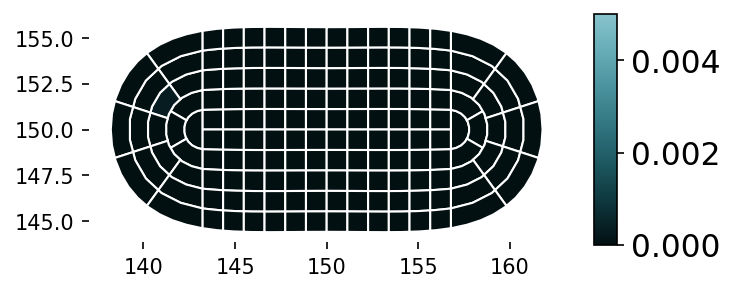

In [15]:
fig, ax = render_map(
    atlas.rep_grid, 
    atlas.data['count_rlp_per_area'].to_dict(), 
    vmin=0, 
    vmax=0.005, 
    cmap=None)

fig.tight_layout()
plt.savefig(folder + '_' + data_name + 'heatmap_oriented.png', dpi=300)
plt.savefig(folder + '_' + data_name + 'heatmap_oriented.svg', dpi=300)